#### Import and ENV

In [1]:
import torch.nn as nn
import torch
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torchmetrics import Accuracy
import importlib
# Local files
import data
importlib.reload(data)
import encoder
importlib.reload(encoder)
import decoder
importlib.reload(decoder)
import main
importlib.reload(main)
import VAE
importlib.reload(VAE)
import training_VAE
importlib.reload(training_VAE)
# Random Seed
torch.manual_seed(0)

Run the following for loop to generate the different modules. Depending on their size, they take a litte over an hour.
The model, a csv of the history, as well as a .png of the recontrcuted image from the test set will be saved in the the Results folder.

In [2]:
# !!!!!!!!!!!Uncomment if you want to run the model training!!! If not, download the model weights from here: 
# z_dim= [10,32,64,128]
# betas= [0,1,2]
# for i in z_dim:
#     for j in betas:
#         main.main(bottle_neck = i, experiment_type=3, beta=j, n_epoch=60, lr= 0.001)
#         print(f"Experiment 3 Done bottle size: {i} Beta{j}")

In [3]:
# from data import get_datasets,dataset_to_dataloader
train_ds, val_ds, test_ds = data.get_datasets()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
##This is for the ease of finding good examples from each category
airplane = [] 
automonile = [] 
bird = []
cat = [] 
deer = [] 
dog = [] 
frog = [] 
horse = [] 
ship = [] 
truck = [] 

for i in test_ds: 
    if i[1] == 0:
        airplane.append(i[0])
    elif  i[1] == 1:
        automonile.append(i[0])
    elif  i[1] == 2:
        bird.append(i[0])
    elif  i[1] == 3:
        cat.append(i[0])
    elif  i[1] == 4:
        deer.append(i[0])
    elif  i[1] == 5:
        dog.append(i[0])
    elif  i[1] == 6:
        frog.append(i[0])
    elif  i[1] == 7:
        horse.append(i[0])
    elif  i[1] == 8:
        ship.append(i[0])
    elif  i[1] == 9:
        truck.append(i[0])
airplane = torch.stack(airplane)
automonile = torch.stack(automonile)
bird = torch.stack(bird)
cat = torch.stack(cat)
deer = torch.stack(deer)
dog = torch.stack(dog)
frog = torch.stack(frog)
horse = torch.stack(horse)
ship = torch.stack(ship)
truck = torch.stack(truck)
        

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for img in tensor:
            for t, m, s in zip(img, self.mean, self.std):
                t.mul_(s).add_(m)
                # The normalize code -> t.sub_(m).div_(s)
          return tensor
        
#Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821

In [6]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for img in tensor:
            for t, m, s in zip(img, self.mean, self.std):
                t.sub_(m).div_(s)
                # The unormalize code -> t.mul_(s).add_(m)
          return tensor
#Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821

In [7]:
from torchvision.utils import make_grid
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))

z_dims= [128, 64, 32, 10]
betas= [0,1,2]
a= 1
fig_output = []
fig_input = torch.stack([airplane[a],
                         automonile[a],
                         bird[a],
                         cat[8],
                         deer[15],
                         dog[0],
                         frog[0],
                         horse[9],
                         ship[a],
                         truck[8],
                         ]).cuda()



In [8]:
with torch.no_grad():
    for beta in betas:
        for z_dim in z_dims:
            out = 512
            latent_dim = z_dim
            encoder_ = encoder.resnet18(pretrained=False)
            encoder_.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            encoder_.fc = nn.Identity()
            decoder_ = decoder.ResNet18Dec(z_dim=latent_dim)
            model = VAE.VAE(encoder_,decoder_,out,latent_dim).to(torch.device('cuda:0'))
            PATH = f"/home/alisa/DL_AutoEncoder/DL-AutoEncoder/Results/VAE_bn_{z_dim}_beta_{beta}.pt"
            model.load_state_dict(torch.load(PATH))
            sample = 1
            counter = 0 
            print(z_dim)
            img_output,mean,var = model(fig_input)
            img_output = img_output.cpu()
            fig_output.append(img_output)

128
64
32
10
128
64
32
10
128
64
32
10


In [9]:
tensor = fig_input.cpu()
for i in fig_output:
    tensor = torch.concat((tensor, i), dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


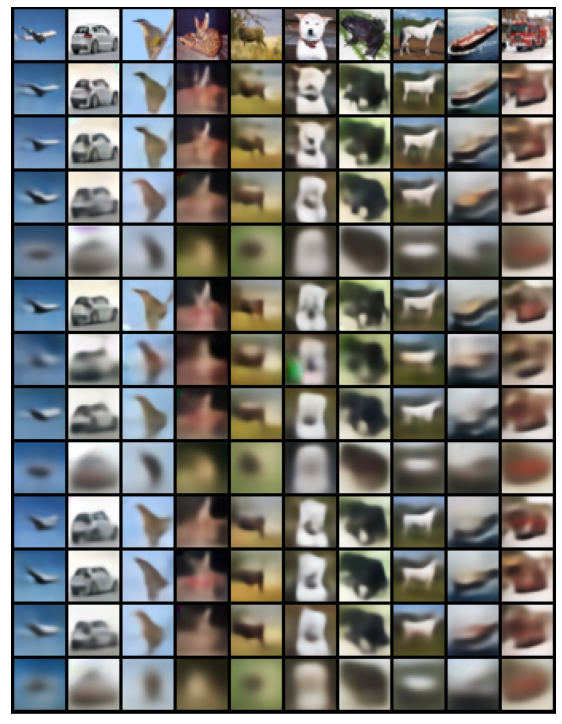

In [10]:
fig, ax = plt.subplots(figsize=(10,13))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(unorm(tensor), nrow=10).permute(1,2,0))

### Generate New Images


In [11]:
def sample(num_samples, latent_dim, decoder_):
    """
    Samples from the latent space and return the corresponding
    image space map.
    :param num_samples: (Int) Number of samples
    :param current_device: (Int) Device to run the model
    :return: (Tensor)
    """
    z = torch.randn(num_samples, latent_dim)
    z = z.cuda()
    samples = decoder_(z)
    return samples

##Ref: https://mlarchive.com/deep-learning/variational-autoencoders-a-vanilla-implementation/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


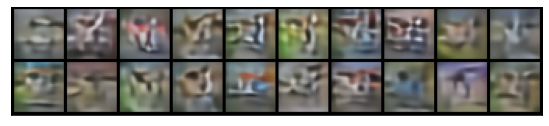

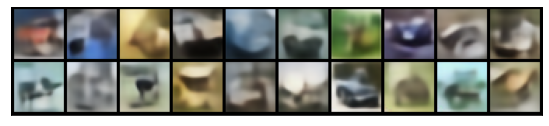

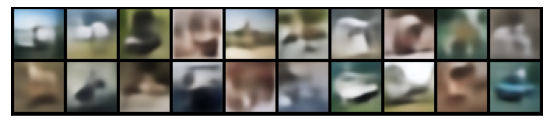

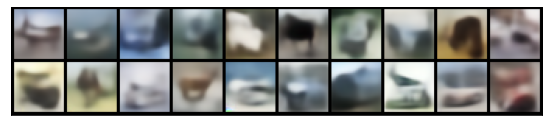

In [12]:
beta = [0,1,2,4]
for i in range(len(beta)):
    with torch.no_grad():
        out = 512
        latent_dim = 128
        encoder_ = encoder.resnet18(pretrained=False)
        encoder_.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        encoder_.fc = nn.Identity()
        decoder_ = decoder.ResNet18Dec(z_dim=latent_dim)
        model = VAE.VAE(encoder_,decoder_,out,latent_dim).to(torch.device('cuda:0'))
        PATH = f"/home/alisa/DL_AutoEncoder/DL-AutoEncoder/Results/VAE_bn_128_beta_{beta[i]}.pt"
        model.load_state_dict(torch.load(PATH))
        model.eval()
        num_samples = 20
        samples = sample(num_samples, latent_dim, decoder_)
        samples_img = samples.cpu().detach()
        fig, ax = plt.subplots(figsize=(10,2))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(unorm(samples_img), nrow=10).permute(1,2,0))
        plt.savefig(f"/home/alisa/DL_AutoEncoder/beta{beta[i]}-reconstructed.png")


### Laplacian Variance

In [13]:
import cv2
def sharpness(path):
    ''' converts image to grayscale, computes laplacian and returns the focus measure(ie varience for the image)
    args:
        image: image path
    returns: 
        Focus measure of image(variance of laplacian)
    '''
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # cv2.imshow("image", gray)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm
#Ref: https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/alisa/DL_AutoEncoder/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] 

laplacian_var for reconstructed data: [8743.90625, 8715.356327160494, 8821.633564814814, 8748.902314814815]
laplacian_var for generated data: [7749.361805555554, 8231.50077160494, 8352.062114197532, 7436.74598765432]


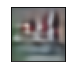

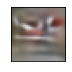

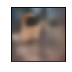

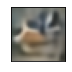

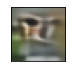

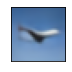

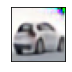

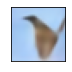

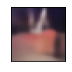

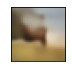

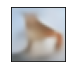

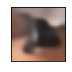

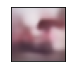

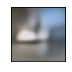

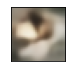

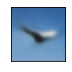

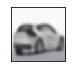

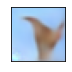

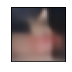

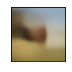

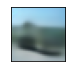

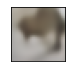

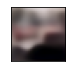

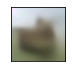

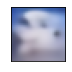

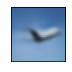

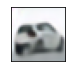

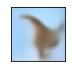

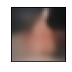

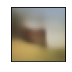

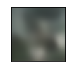

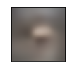

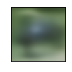

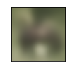

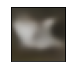

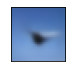

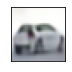

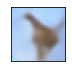

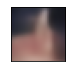

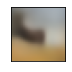

In [23]:
#Genearted Images
betas = [0,1,2,4]
laplacian_var_reconstruction = [] 
laplacian_var_generated = [] 
    #Load Model
for beta in betas:
    with torch.no_grad():
        out = 512
        latent_dim = 128
        encoder_ = encoder.resnet18(pretrained=False)
        encoder_.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        encoder_.fc = nn.Identity()
        decoder_ = decoder.ResNet18Dec(z_dim=latent_dim)
        model = VAE.VAE(encoder_,decoder_,out,latent_dim).to(torch.device('cuda:0'))
        PATH = f"/home/alisa/DL_AutoEncoder/DL-AutoEncoder/Results/VAE_bn_128_beta_{beta}.pt"
        model.load_state_dict(torch.load(PATH))
        model.eval()

    #Generate 5 Images, and save them 
    for i in range(0,5):
        num_samples = 1
        latent_dim = 128 
        samples = sample(num_samples, latent_dim, decoder_).cpu().detach()
        samples_img = samples.cpu().detach()
        fig, ax = plt.subplots(figsize=(1,1))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(unorm(samples_img), nrow=1).permute(1,2,0))
        plt.savefig(f"/home/alisa/DL_AutoEncoder/beta{beta}-generated{i}.png")

     #Reconstrcut 5 Images, and save them 
    for i in range(0,5):
        latent_dim = 128 
        output,_,_ = model(fig_input[i].unsqueeze(0).cuda())
        fig, ax = plt.subplots(figsize=(1,1))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(unorm(output.detach().cpu()), nrow=1).permute(1,2,0))
        plt.savefig(f"/home/alisa/DL_AutoEncoder/beta{beta}-reconstrcution{i}.png")

    beta_sharpness_gen = []
    beta_sharpness_rec = []
    for i in range(0,5):
        path = f"/home/alisa/DL_AutoEncoder/beta{beta}-generated{i}.png"
        beta_sharpness_gen.append(sharpness(path))
        path = f"/home/alisa/DL_AutoEncoder/beta{beta}-reconstrcution{i}.png"
        beta_sharpness_rec.append(sharpness(path))
    laplacian_var_reconstruction.append(np.mean(beta_sharpness_rec))
    laplacian_var_generated.append(np.mean(beta_sharpness_gen))
print("laplacian_var for reconstructed data:", laplacian_var_reconstruction)
print("laplacian_var for generated data:", laplacian_var_generated)

### Feature Maps

https://github.com/alexander-soare/torchvision_feature_extraction_walkthrough

In [15]:
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import cv2

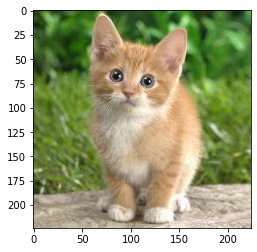

In [16]:
input_img = cv2.imread('cat_224x224.jpg',)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
input_tensor = data.transform(input_img)
input_tensor = input_tensor.expand((1,3,224,224))

In [17]:
encoder_ = encoder.resnet18(pretrained=False)
encoder_.avgpool = nn.AdaptiveAvgPool2d((1, 1))
encoder_.fc = nn.Identity()
decoder_ = decoder.ResNet18Dec(z_dim=64)
model = VAE.VAE(encoder_,decoder_,512,64)

model.load_state_dict(torch.load('./Results/Frozen_VAE_bn_64_beta_0.pt'))
model = model.encoder
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
train_nodes, eval_nodes = get_graph_node_names(model)
eval_nodes

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.add',
 'layer1.0.relu_1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.add',
 'layer1.1.relu_1',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_1',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.add',
 'layer2.1.relu_1',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample.0',
 'layer3.0.downsample.1',
 'layer3.0.add',
 'layer3.0.relu_1',
 'layer3.1.conv1',
 'layer3.1.bn1',
 'layer3.1.relu',
 'layer3.1.conv2',
 'layer3.1.bn2',
 'layer3.1.add',
 'layer3.1.relu_1',
 'layer4.0.conv1',
 'layer4.0.bn1',
 'layer4.0.relu',
 'layer4.0.conv2',
 'layer4.0.bn2',

In [19]:
return_nodes = ['layer1', 'layer2', 'layer3', 'layer4']
feat_ext = create_feature_extractor(model, return_nodes=return_nodes)

In [20]:
with torch.no_grad():
    out = feat_ext(input_tensor)

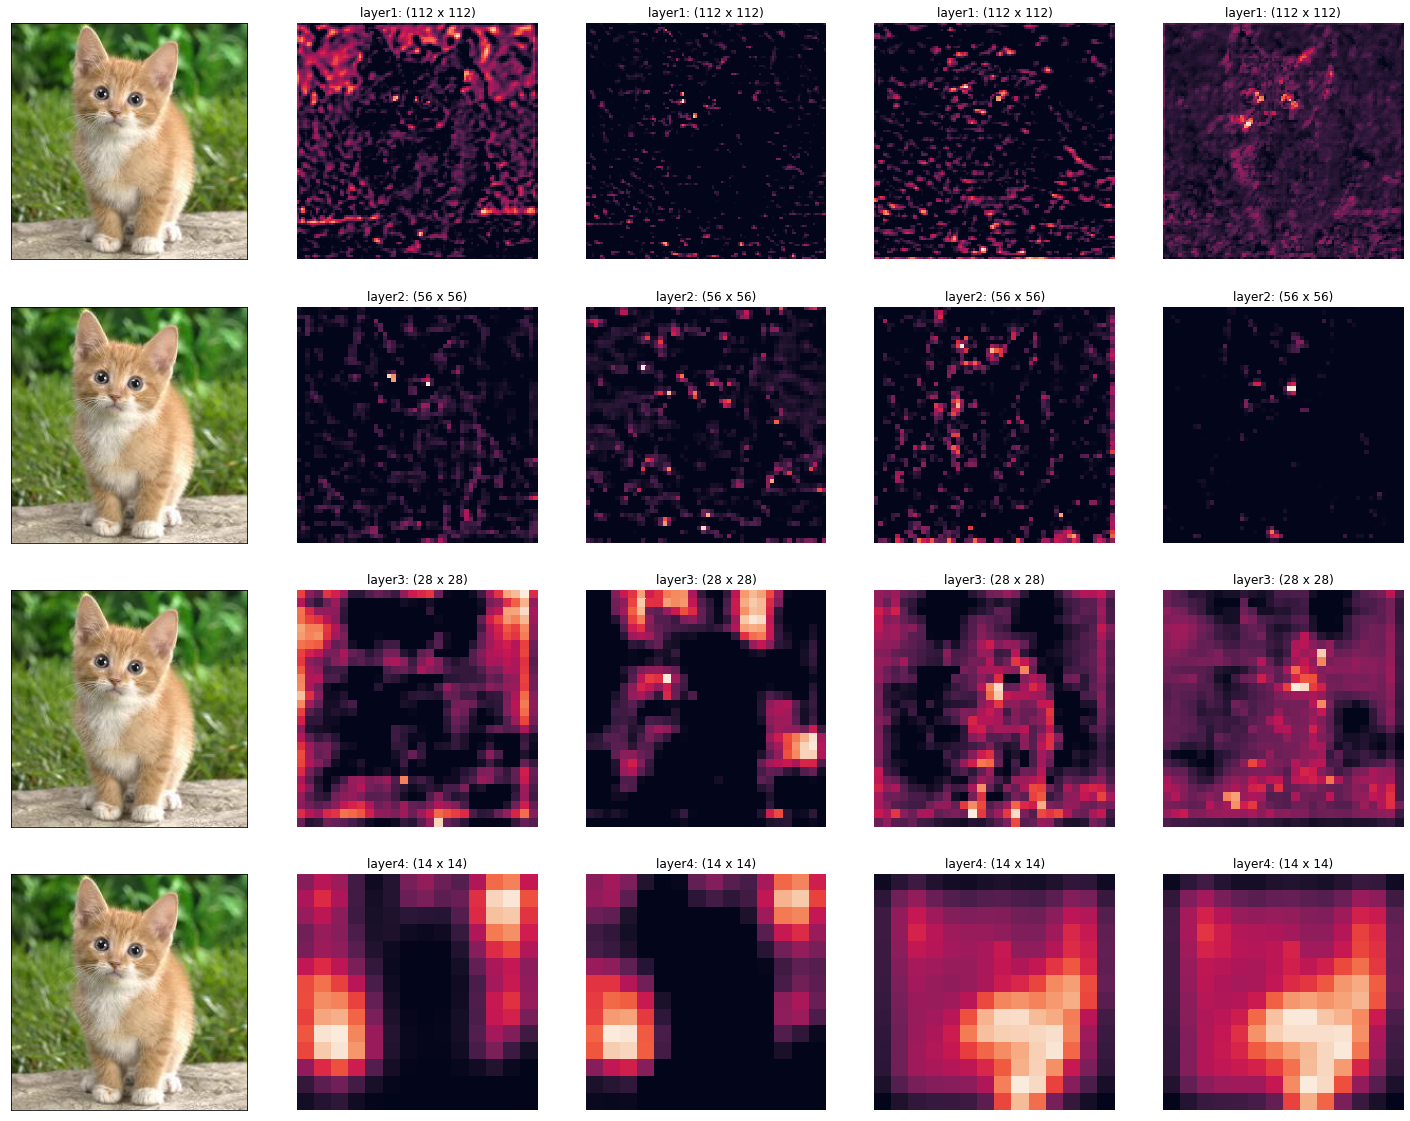

In [21]:
fig, ax = plt.subplots(4,5, figsize = (25,20))

for i, layer in enumerate(return_nodes):
    feat_maps = out[layer].numpy().squeeze(0)
    feat_maps = random.sample(list(feat_maps), 4)
    ax[i][0].imshow(input_img)
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j, feat_map in enumerate(feat_maps):
        sns.heatmap(feat_map, ax=ax[i][j+1], cbar = False)
        ax[i][j+1].set_xticks([])
        ax[i][j+1].set_yticks([])
        ax[i][j+1].set_title(f'{layer}: ({feat_map.shape[0]} x {feat_map.shape[1]})')